In [7]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
import csv
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.data import BiasedRandomWalk
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import pickle 

# Load dataset

In [8]:
# Create graph from csv file with edge weights (we loose some edges as this data would require a multidigraph)
def parse_ckn_csv(fname):
    g = nx.MultiDiGraph()
    g.name = "ckn_v2022-05-16_JNB_5_6"
    fields = ['from', 'to', 'intType', 'reliability', 'species']
    with open(fname, newline='') as csvfile:
        reader = csv.DictReader(csvfile, fieldnames=fields, dialect=csv.excel_tab, restkey='rest', )
        for i, row in enumerate(reader):
            if i == 0:
                continue
            if row['intType'] != "binding":
                g.add_edge(row['from'], row['to'], type=row['intType'], reliability=row['reliability'])
            elif row['intType'] == "binding":
                g.add_edge(row['from'], row['to'], type=row['intType'], reliability=row['reliability'])
                g.add_edge(row['to'], row['from'], type=row['intType'], reliability=row['reliability'])
            else:
                print(row)
                raise SyntaxError
    return g

In [9]:
g = parse_ckn_csv("../data/AtCKN_2022-01-26_mod_v2022-05-16.tsv")
nx.write_gpickle(g, f"Results/nx_graph_{g.name}.gpickle")

In [10]:
nx.info(g)

"MultiDiGraph named 'ckn_v2022-05-16_JNB_5_6' with 26159 nodes and 881280 edges"

In [11]:
# Check for errors in the graph
print(sorted(g.nodes)[:20])
print(sorted(g.nodes)[-20:])
isolated = list(nx.isolates(g))
print(f"isolated nodes={isolated}")
#g.remove_nodes_from(isolated)

['AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050', 'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01090', 'AT1G01100', 'AT1G01110', 'AT1G01120', 'AT1G01130', 'AT1G01140', 'AT1G01160', 'AT1G01170', 'AT1G01180', 'AT1G01183', 'AT1G01190', 'AT1G01200']
['MIRF11184', 'MIRF11185', 'MIRF11186', 'MIRF11187', 'MIRF11188', 'MIRF11189', 'MIRF11190', 'MIRF11191', 'MIRF11192', 'MIRF11193', 'MIRF11194', 'MIRF11195', 'MIRF11196', 'MIRF11197', 'MIRF11198', 'MIRF11199', 'MIRF11200', 'MIRF11201', 'MIRF11202', 'MIRF11203']
isolated nodes=[]


In [12]:
list(g.edges(data=True))[:10]

[('AT1G01010', 'AT1G01010', {'type': 'unkTF', 'reliability': 'r3'}),
 ('AT1G01010', 'AT1G07640', {'type': 'binding', 'reliability': 'r3'}),
 ('AT1G01010', 'AT1G10030', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G12390', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G14360', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G16240', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G17080', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G18330', {'type': 'binding', 'reliability': 'r3'}),
 ('AT1G01010', 'AT1G21790', {'type': 'binding', 'reliability': 'r2'}),
 ('AT1G01010', 'AT1G25280', {'type': 'binding', 'reliability': 'r4'})]

In [13]:
# Some general characteristics of the graph
print(f'nodes={g.number_of_nodes()}, edges={g.number_of_edges()}, density: {nx.density(g):.4f}')

nodes=26159, edges=881280, density: 0.0013


In [14]:
nx.is_weakly_connected(g)

False

In [15]:
# List of weakly connected components
print("Number of weakly connected components:", len(list(nx.weakly_connected_components(g))))

Number of weakly connected components: 151


In [16]:
#Generate a sorted list of weakly connected component, largest first.
from collections import Counter
from pprint import pprint
cc_sizes = Counter()
for cc in nx.weakly_connected_components(g):
    cc_sizes[len(cc)] += 1
pprint(sorted(cc_sizes.items(), reverse=True))

[(25737, 1),
 (31, 1),
 (16, 1),
 (13, 1),
 (12, 1),
 (8, 1),
 (7, 1),
 (5, 3),
 (4, 14),
 (3, 17),
 (2, 103),
 (1, 7)]


There is only one large weakly connected component that rest are negligible.

Do we keep only the one biggest component?

In [17]:
# identify the largest weakly connected component and create a corresponding subgraph
largest_cc = max(nx.weakly_connected_components(g), key=len)
print(f"biggest component size={len(largest_cc)}")
g = g.subgraph(largest_cc)

# Some general characteristics of the subgraph
print(f"Subgraph nodes={g.number_of_nodes()}, subgraph edges={g.number_of_edges()}, density: {nx.density(g):.4f}")

biggest component size=25737
Subgraph nodes=25737, subgraph edges=880337, density: 0.0013


# Link prediction

In [18]:
G = StellarGraph.from_networkx(g)

# # Dump graph
# with open("Results/notebook/StellarGraph.p", 'wb') as f:
#     pickle.dump(G, f)

In [19]:
# # Load graph
# with open("Results/notebook/StellarGraph.p", 'rb') as f:
#     G_loaded = pickle.load(f)

In [20]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 25737, Edges: 880337

 Node types:
  default: [25737]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [880337]
        Weights: all 1 (default)
        Features: none


## Construct train-test splits of the graph data

### Test Graph (graph_test)

We create the test graph and test set of positive/negative edge examples from the full graph. 
* graph_test = reduced graph obtained by removing the test set of edges from the full graph. [same as source]
* examples_test = set of positive/negative edge examples (node pairs) [np_array]
* labels_test = labels of pos and neg edges (1, 0) [np_array]

In [21]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p of all positive links, and same number of negative links, from full graph, and obtain the
# reduced graph graph_test with the sampled positive links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 88033 positive and 88033 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 25737, Edges: 792304

 Node types:
  default: [25737]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [792304]
        Weights: all 1 (default)
        Features: none


In [22]:
examples_test

array([['AT2G26770', 'AT5G41790'],
       ['AT4G39260', 'AT4G26700'],
       ['MIRF10391', 'AT3G30700'],
       ...,
       ['AT5G61270', 'AT3G04070'],
       ['AT1G28695', 'AT3G01860'],
       ['ATCG01080', 'AT4G04690']], dtype=object)

In [23]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

### Train Graph

We use EdgeSplitter on Test Graph and perform  train/test split to create:
* Train Graph
* Training set of edge examples
* Model selection set of edge examples

In [24]:
# Same as above to produce a training subset from the Test Graph (graph_test)
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 79230 positive and 79230 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 25737, Edges: 713074

 Node types:
  default: [25737]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [713074]
        Weights: all 1 (default)
        Features: none


Summary of the different 

In [25]:
# Overview of splits created
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,118845,Train Graph,Test Graph,Train the Link Classifier
Model Selection,39615,Train Graph,Test Graph,Select the best Link Classifier model
Test set,176066,Test Graph,Full Graph,Evaluate the best Link Classifier


## Node embeddings

Use Node2vec to generate the node embeddings with random walks, which try to maintain the node similarity from the graph (proximity in the embedding space). Output are node pairs, which are used to train a Word2Vec model.

### Node2Vec 

In [26]:
# parameters
p = 1.0
q = 1.0
dimensions = 128
num_walks = 50
walk_length = 40
window_size = 5
epochs = 1
workers = int(multiprocessing.cpu_count() / 2)

In [27]:
global model 

def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")
    
    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=epochs,
    )
    
    def get_embedding(u):
        return model.wv[u]
    
    return get_embedding

In [28]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")
# lahk tudi kar tukaj poženeš classifier

Number of random walks for 'Train Graph': 1286850


In [29]:
embedding_train('AT1G01010')

array([-2.22733933e-02, -4.00304735e-01, -2.37144351e-01,  3.43349427e-01,
        8.26988518e-02,  3.99119049e-01, -5.53982496e-01,  8.50293487e-02,
        2.03556925e-01, -1.33932963e-01,  2.09000319e-01, -2.02916369e-01,
       -1.46502629e-01, -1.17859983e+00, -1.10434279e-01,  7.49197781e-01,
        6.87861666e-02,  2.59833455e-01, -1.60148948e-01,  4.89530921e-01,
        3.51793587e-01, -1.59917131e-01, -2.29730934e-01, -1.01846509e-01,
       -3.01196337e-01,  4.43546861e-01, -5.03448367e-01,  1.42453417e-01,
       -2.69220173e-01,  4.04257715e-01,  6.07335806e-01,  4.38704252e-01,
        1.20928615e-01, -2.38375999e-02, -8.70960295e-01, -4.56206977e-01,
        4.40691113e-01,  5.77389300e-02, -1.51155099e-01,  2.64487833e-01,
       -2.24940822e-01,  1.59586281e-01, -3.00679803e-01, -4.41704750e-01,
       -1.24197088e-01,  2.50776857e-02,  3.10547054e-02,  1.08308807e-01,
        2.67080992e-01,  3.25720161e-02,  1.82050169e-01,  8.83885100e-03,
        5.44401824e-01, -

## Train and evaluate the link prediction model

To use Word2Vec model for link prediction we need to perform these steps:
1. Calculate the edge embeddings for positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes
2. Train classifier to predicta binary label
3. Evaluate the perfromance of the link classifier for each binary operator on training data with node embeddings calculated on the Train Graph and select the best classifier
4. The best classifier is used to calculate scores on the test data with node embeeddings calcluated on the Test Graph.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. Edge embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. Training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    print("---------->", clf.classes_)
    return clf

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
                                                          
# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score, predicted = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score, predicted

def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features) ## verjetnosti za napovedi 

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column]), predicted

We use 4 different binary operators that produce link embeddings that have equal dimensionality to the input node embeddings. 

In [31]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [32]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")
      
pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"][0]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

----------> [0 1]
----------> [0 1]
----------> [0 1]
----------> [0 1]
Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,0.964101
operator_l1,0.886806
operator_l2,0.889539
operator_avg,0.817948


### Evaluate the best model using the test set

We now use the test set of embeddings and calculate a final evaluation score. 

In [33]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 1286850


In [34]:
test_score, predicted = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_hadamard': 0.8837896281498968


### Create df of edges with R values and predictions

In [35]:
# Edges test examples is set of positive/negative edge examples (node pairs) that were removed from the full graph. [np_array]
examples_test

array([['AT2G26770', 'AT5G41790'],
       ['AT4G39260', 'AT4G26700'],
       ['MIRF10391', 'AT3G30700'],
       ...,
       ['AT5G61270', 'AT3G04070'],
       ['AT1G28695', 'AT3G01860'],
       ['ATCG01080', 'AT4G04690']], dtype=object)

In [36]:
# Labels of pos and neg edges (1, 0) for test edges examples [np_array]
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [37]:
# Label predicitons for each edge test example
predicted

array([[2.73148635e-02, 9.72685136e-01],
       [5.16265980e-01, 4.83734020e-01],
       [5.27209387e-11, 1.00000000e+00],
       ...,
       [3.14173043e-01, 6.85826957e-01],
       [4.19981963e-01, 5.80018037e-01],
       [7.68922753e-01, 2.31077247e-01]])

In [38]:
# Create df with the test data and predictions
df_pred = pd.DataFrame(examples_test, columns=["from", "to"])
df_pred["labels"] = labels_test
df_pred[["pred_0", "pred_1"]] = pd.DataFrame(predicted)
# df_pred.drop(["pred_0"], axis=1, inplace=True)
df_pred["R-value"] = np.nan
df_pred

,from,to,labels,pred_0,pred_1,R-value
0,AT2G26770,AT5G41790,1,2.731486e-02,0.972685,NaN
1,AT4G39260,AT4G26700,1,5.162660e-01,0.483734,NaN
2,MIRF10391,AT3G30700,1,5.272094e-11,1.000000,NaN
3,AT5G13300,AT1G47830,1,2.664580e-01,0.733542,NaN
4,AT2G43000,AT3G01080,1,4.521225e-03,0.995479,NaN
...,...,...,...,...,...,...
176061,AT1G30490,AT1G17270,0,5.887197e-01,0.411280,NaN
176062,AT4G17250,MIRF10029,0,3.380719e-02,0.966193,NaN
176063,AT5G61270,AT3G04070,0,3.141730e-01,0.685827,NaN
176064,AT1G28695,AT3G01860,0,4.199820e-01,0.580018,NaN


---

In [39]:
df = pd.read_csv("../data/AtCKN_2022-01-26.tsv", 
                 names=["from", "to", "interaction", "R-value", "pis"], sep="\t", header=0)
df

,from,to,interaction,R-value,pis
0,AT1G01010,AT1G01010,unkTF,r3,ath
1,AT1G01010,AT1G07640,binding,r3,ath
2,AT1G01010,AT1G10030,binding,r2,ath
3,AT1G01010,AT1G12390,binding,r2,ath
4,AT1G01010,AT1G14360,binding,r2,ath
...,...,...,...,...,...
484611,MIRF11203,AT3G43955,inhMIR,r3,ath
484612,MIRF11203,AT3G52530,inhMIR,r3,ath
484613,MIRF11203,AT5G12085,inhMIR,r3,ath
484614,MIRF11203,AT5G35935,inhMIR,r3,ath


In [40]:
# test uniqueness
a = set()
for i, row in df.iterrows():
    a.add((row["from"], row["to"], row["interaction"]))
print(len(a))
    

484616


In [41]:
df["interaction"].value_counts()

binding       396664
inhMIR         33377
catalysis      27963
unkTF          15279
actTF           5412
activation      1687
ptmod           1427
inhTF           1349
inhibition      1292
PTRmod           166
Name: interaction, dtype: int64

In [42]:
df["R-value"].value_counts(normalize=True)

r3    0.788998
r2    0.093466
r4    0.060832
r1    0.056705
Name: R-value, dtype: float64

<AxesSubplot:>

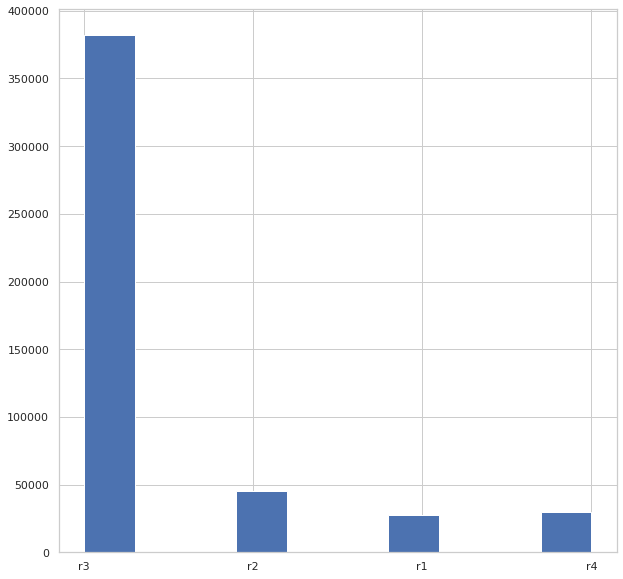

In [43]:
df["R-value"].hist()

---

In [44]:
# Create dictionary edge : R-value from original df
dict_org ={}

for row in df.itertuples(name=None):
    dict_org[row[1:3]] = row[4]

# Create tuple edges in df_pred
data_edges = list(zip(df_pred["from"], df_pred["to"]))

df_pred.insert(2, "edge_tuple", value=data_edges)

In [45]:
# Map R-values from original data to positive edges in df_pred
r_values = []
for rid, row in df_pred.iterrows():
    if g.has_edge(row["from"], row["to"]):
        r_values.append(g.edges[row["from"], row["to"], 0]["reliability"])
    else: 
        r_values.append(np.nan)
df_pred["R-value"] = r_values
df_pred

,from,to,edge_tuple,labels,pred_0,pred_1,R-value
0,AT2G26770,AT5G41790,"(AT2G26770, AT5G41790)",1,2.731486e-02,0.972685,r4
1,AT4G39260,AT4G26700,"(AT4G39260, AT4G26700)",1,5.162660e-01,0.483734,r4
2,MIRF10391,AT3G30700,"(MIRF10391, AT3G30700)",1,5.272094e-11,1.000000,r3
3,AT5G13300,AT1G47830,"(AT5G13300, AT1G47830)",1,2.664580e-01,0.733542,r4
4,AT2G43000,AT3G01080,"(AT2G43000, AT3G01080)",1,4.521225e-03,0.995479,r3
...,...,...,...,...,...,...,...
176061,AT1G30490,AT1G17270,"(AT1G30490, AT1G17270)",0,5.887197e-01,0.411280,NaN
176062,AT4G17250,MIRF10029,"(AT4G17250, MIRF10029)",0,3.380719e-02,0.966193,NaN
176063,AT5G61270,AT3G04070,"(AT5G61270, AT3G04070)",0,3.141730e-01,0.685827,NaN
176064,AT1G28695,AT3G01860,"(AT1G28695, AT3G01860)",0,4.199820e-01,0.580018,NaN


In [46]:
df_pred.to_pickle(f"Results/df_pred_{g.name}.pickle")
df_pred.to_csv(f"Results/df_pred_poz&neg-links_{g.name}", na_rep="?", index= False)

---

Prepare dataset of positive edges with predictions and visualisation.

In [47]:
# read pickle
#df_pred = pd.read_pickle('<path>')

In [48]:
df_poz = df_pred[df_pred.labels == 1]
df_poz["R-value"].value_counts(dropna=False)

r4    41734
r3    35725
r2     7052
r1     3522
Name: R-value, dtype: int64

In [49]:
df_poz["R-value"].value_counts(normalize=True)

r4    0.474072
r3    0.405814
r2    0.080106
r1    0.040008
Name: R-value, dtype: float64

In [50]:
df_poz

,from,to,edge_tuple,labels,pred_0,pred_1,R-value
0,AT2G26770,AT5G41790,"(AT2G26770, AT5G41790)",1,2.731486e-02,0.972685,r4
1,AT4G39260,AT4G26700,"(AT4G39260, AT4G26700)",1,5.162660e-01,0.483734,r4
2,MIRF10391,AT3G30700,"(MIRF10391, AT3G30700)",1,5.272094e-11,1.000000,r3
3,AT5G13300,AT1G47830,"(AT5G13300, AT1G47830)",1,2.664580e-01,0.733542,r4
4,AT2G43000,AT3G01080,"(AT2G43000, AT3G01080)",1,4.521225e-03,0.995479,r3
...,...,...,...,...,...,...,...
88028,AT2G34710,AT5G15550,"(AT2G34710, AT5G15550)",1,2.316811e-01,0.768319,r4
88029,AT5G65180,AT5G45600,"(AT5G65180, AT5G45600)",1,9.622585e-03,0.990377,r3
88030,AT5G06320,AT4G22730,"(AT5G06320, AT4G22730)",1,1.925563e-02,0.980744,r2
88031,AT2G02040,AT1G20260,"(AT2G02040, AT1G20260)",1,3.859697e-02,0.961403,r3


In [51]:
# Check distribution of R-value among predictions with high probability for label 1 (existing link).
df_poz.loc[df_poz["pred_1"] >= 0.90]["R-value"].value_counts(normalize=True)

r3    0.475347
r4    0.402921
r2    0.078772
r1    0.042961
Name: R-value, dtype: float64

### Graf korelacije R in predikcij 


In [52]:
# box graf; če naraščajo intervali (boxi) med Ri je kul, če ravno ni korelacije;

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
plot_data = df_poz
plot_data

,from,to,edge_tuple,labels,pred_0,pred_1,R-value
0,AT2G26770,AT5G41790,"(AT2G26770, AT5G41790)",1,2.731486e-02,0.972685,r4
1,AT4G39260,AT4G26700,"(AT4G39260, AT4G26700)",1,5.162660e-01,0.483734,r4
2,MIRF10391,AT3G30700,"(MIRF10391, AT3G30700)",1,5.272094e-11,1.000000,r3
3,AT5G13300,AT1G47830,"(AT5G13300, AT1G47830)",1,2.664580e-01,0.733542,r4
4,AT2G43000,AT3G01080,"(AT2G43000, AT3G01080)",1,4.521225e-03,0.995479,r3
...,...,...,...,...,...,...,...
88028,AT2G34710,AT5G15550,"(AT2G34710, AT5G15550)",1,2.316811e-01,0.768319,r4
88029,AT5G65180,AT5G45600,"(AT5G65180, AT5G45600)",1,9.622585e-03,0.990377,r3
88030,AT5G06320,AT4G22730,"(AT5G06320, AT4G22730)",1,1.925563e-02,0.980744,r2
88031,AT2G02040,AT1G20260,"(AT2G02040, AT1G20260)",1,3.859697e-02,0.961403,r3


<AxesSubplot:>

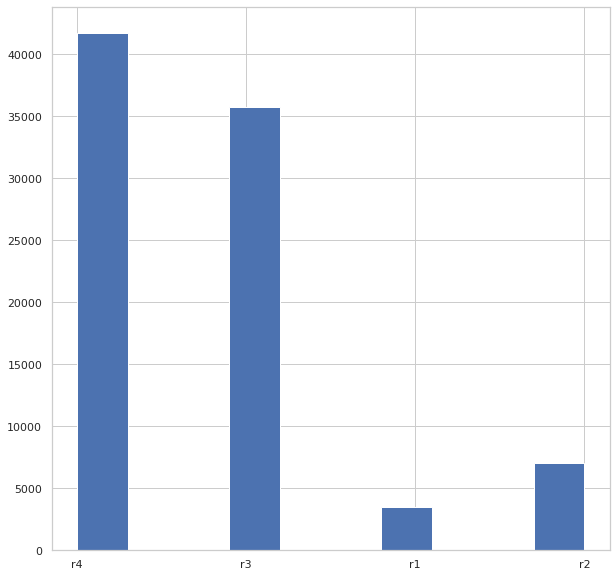

In [55]:
plot_data["R-value"].hist()

In [56]:
# # plot distribution of predictions for all R-values.
# plot_data.pred_1.hist()

In [57]:
# Bin probabilities into intervals
bins = np.arange(1, 11, 1)
plt_data = plot_data.copy()
plt_data["intervals"] = pd.cut(plot_data["pred_1"], 10, labels=bins)
plt_data["intervals"].value_counts()
plt_data

,from,to,edge_tuple,labels,pred_0,pred_1,R-value,intervals
0,AT2G26770,AT5G41790,"(AT2G26770, AT5G41790)",1,2.731486e-02,0.972685,r4,10
1,AT4G39260,AT4G26700,"(AT4G39260, AT4G26700)",1,5.162660e-01,0.483734,r4,5
2,MIRF10391,AT3G30700,"(MIRF10391, AT3G30700)",1,5.272094e-11,1.000000,r3,10
3,AT5G13300,AT1G47830,"(AT5G13300, AT1G47830)",1,2.664580e-01,0.733542,r4,8
4,AT2G43000,AT3G01080,"(AT2G43000, AT3G01080)",1,4.521225e-03,0.995479,r3,10
...,...,...,...,...,...,...,...,...
88028,AT2G34710,AT5G15550,"(AT2G34710, AT5G15550)",1,2.316811e-01,0.768319,r4,8
88029,AT5G65180,AT5G45600,"(AT5G65180, AT5G45600)",1,9.622585e-03,0.990377,r3,10
88030,AT5G06320,AT4G22730,"(AT5G06320, AT4G22730)",1,1.925563e-02,0.980744,r2,10
88031,AT2G02040,AT1G20260,"(AT2G02040, AT1G20260)",1,3.859697e-02,0.961403,r3,10


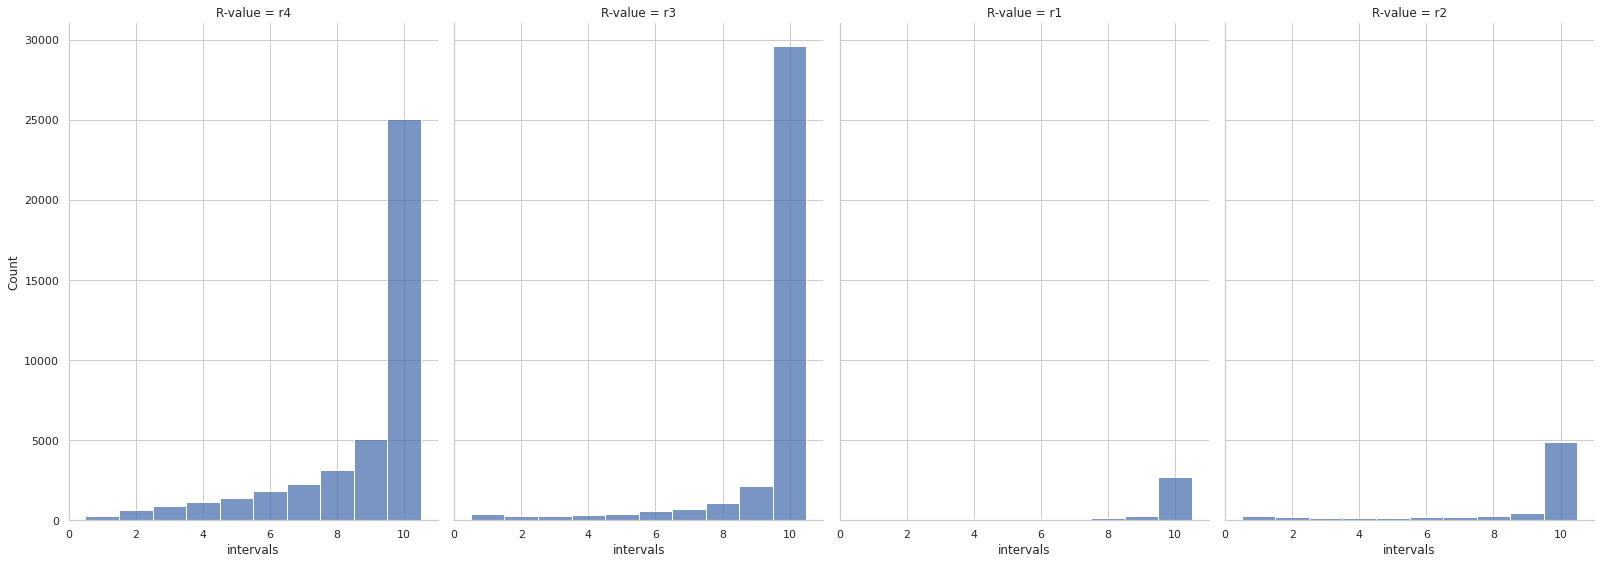

In [58]:
# plot distribution of predicted probabilities for individual R-values.

r_plt = sns.FacetGrid(plt_data[plot_data["R-value"] != ""], col="R-value", height=8, aspect=.7)
r_plt.map(sns.histplot, "intervals")

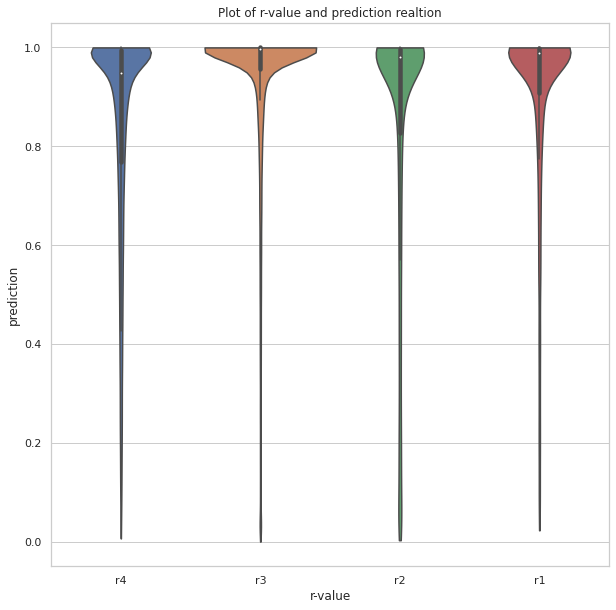

In [59]:
# plot with seaborn

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_theme(style="whitegrid")
sns.violinplot(x="R-value", 
                   y="pred_1",
                   data=plot_data, 
                   order=["r4", "r3", "r2", "r1"], 
                   #scale="count",
#                    inner="quartile",
#                    palette="Set2",
                   cut=0)

plt.xlabel("r-value")
plt.ylabel("prediction")
plt.title("Plot of r-value and prediction realtion")
plt.savefig(f"Results/CKN_violinPlot_{g.name}_not-normalised.png")

In [ ]:
# plot with seaborn

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_theme(style="whitegrid")
sns.violinplot(x="R-value", 
                   y="pred_1",
                   data=plot_data, 
                   order=["r4", "r3", "r2", "r1"], 
                   scale="count",
#                    inner="quartile",
#                    palette="Set2",
                   cut=0)

plt.xlabel("r-value")
plt.ylabel("prediction")
plt.title("Plot of r-value and prediction realtion")
plt.savefig(f"Results/CKN_violinPlot_{g.name}.png")